<a href="https://colab.research.google.com/github/praveentn/ml-repos/blob/master/qc/pennylane/QML_Regression_Model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***QUANTUM MACHINE LEARNING MODEL PREDICTOR FOR CONTINUOUS VARIABLE***

By Roberth Saénz Pérez Alvarado , roberthspa@gmail.com, rpereza@uni.pe




According to this paper: "Predicting toxicity by quantum machine learning" (Teppei Suzuki, Michio Katouda 2020) https://arxiv.org/abs/2008.07715 is possible to predict continuous variables using 2 qbits per feature applying encodings, variational circuits and some lineal transformations on expected values in order to predict values close to real target. 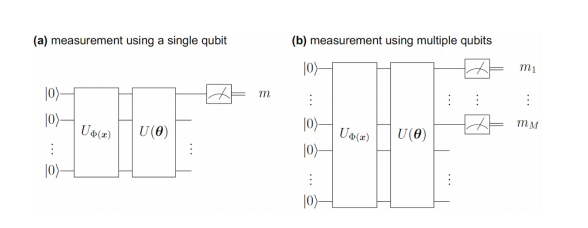 

Image from: https://arxiv.org/ftp/arxiv/papers/2008/2008.07715.pdf 
I uploaded the following example from https://pennylane.ai/qml/demos/quantum_neural_net using PennyLane libraries, a short dataset which consist on 1 variable input and 1 output, so that the processing does not take too much time.

In [1]:
pip install numba==0.49.1

     |████████████████████████████████| 3.6 MB 5.2 MB/s 
     |████████████████████████████████| 20.2 MB 67.7 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [2]:
pip install tensornetwork==0.3

     |████████████████████████████████| 216 kB 5.3 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
!pip install pennylane pennylane-sf 
import pennylane
dev = pennylane.device('default.qubit', wires=2)

     |████████████████████████████████| 514 kB 5.4 MB/s 
     |████████████████████████████████| 4.9 MB 47.1 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
     |████████████████████████████████| 138 kB 56.8 MB/s 
     |████████████████████████████████| 47 kB 4.5 MB/s 
     |████████████████████████████████| 112 kB 58.7 MB/s 
     |████████████████████████████████| 127 kB 56.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=4d75569f8698ee08b786e0af09ac750ef6993fd4fc8955bfeb65aadfa82d77e7
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [17]:
import urllib
from io import StringIO

SINE_URL = "https://raw.githubusercontent.com/XanaduAI/pennylane/v0.3.0/examples/data/sine.txt"
count = 0

sine = []

data = urllib.request.urlopen(SINE_URL)
for line in data:
    d = line.decode("utf-8").strip()
    sine.append(d.split(" "))
    # print(line.decode("utf-8"))
    
df = pd.DataFrame(sine)
df.head()

,0,1
0,-1.126864863386807247e-01,-3.708159070558681991e-01
1,-3.301285119623154074e-01,-7.792427358570894746e-01
2,5.437373320144804900e-01,1.054098341344321677e+00
3,8.070486641099010594e-01,5.322417543552232511e-01
4,5.553805663845667873e-01,9.748881583874732248e-01


In [54]:
df.describe()

,0,1
count,50.000000,50.000000
mean,0.051329,-0.000046
std,0.554555,0.799718
min,-0.865836,-1.167565
25%,-0.457141,-0.802728
50%,0.088861,0.100107
75%,0.542681,0.714016
max,0.967816,1.293714


In [32]:
print(df.dtypes)
df[0] = df[0].astype('float')
df[1] = df[1].astype('float')
print(df.dtypes)


0    object
1    object
dtype: object
0    float64
1    float64
dtype: object


With dataset from https://pennylane.ai/qml/demos/quantum_neural_net.html for evaluating if the algorithm can capture the nonlineality of this data.

In [33]:
# # data = np.loadtxt("sine.txt")

# data = pd.read_url(SINE_URL)
# print(data.shape)

# X = data[:, 0]

# Y = data[:, 1]

In [34]:
X = df[0].values
Y = df[1].values

X.shape, Y.shape

((50,), (50,))

For encoding data, the autors (Teppei Suzuki, Michio Katouda 2020) use qbits rotations followed by 2 qbits entangled states in the form: U(x)-CNOT-U(x)-CNOT.


In [35]:
def statepreparation(x, nqbits):

    qml.RY(x, wires=[0])
    qml.RZ(x, wires=[0])
    qml.RY(x, wires=[1])
    qml.RZ(x, wires=[1])
    
    for q in range(nqbits-1):
        qml.CNOT(wires=[q, q+1])
    
    qml.RY(x, wires=[0])
    qml.RZ(x, wires=[0])
    qml.RY(x, wires=[1])
    qml.RZ(x, wires=[1])
        
    for q in range(nqbits-1):
      
        qml.CNOT(wires=[q, q+1])

Then applying variational circuits constructed by "ℓ" layers consisted of singles qbits rotations 𝑈ℓ(𝜽ℓ) and two-qbit entangler blocks comprising CNOT gates.

In [36]:
def layer(theta):
    nqbits=len(theta[0])
    nlayer=len(theta)
    
    for l in range(nlayer):
        
        for i in range(nqbits-1):
            qml.CNOT(wires=[i, i+1])
      
        for q in range(nqbits):
            theta0=theta[l][q][0]
            theta1=theta[l][q][1]
            theta2=theta[l][q][2]
            qml.RX(theta0, wires=[q])
            qml.RZ(theta1, wires=[q])
            qml.RX(theta2, wires=[q])        

Then designing the quantum circuit in order to get as ouput a list of measure expecting values by Pauli Z operator on each qbit.

In [37]:
nqbits=2
dev = qml.device("default.qubit", wires=nqbits)  

@qml.qnode(dev)
def qcircuit(theta, x):
    measure=[]
    nqbits=len(theta[0])
    statepreparation(x, nqbits)
    layer(theta)
    for i in range(nqbits):
        zeta=qml.expval(qml.PauliZ([i]))
        measure.append(zeta)
    return measure

Once we get the set of expected values, these will use these measure list "m" as input for a multiple linear model. So for a set of expectation values from 𝑀 qubits for 𝑖th data, the predicted value 𝑦 can be expressed as:

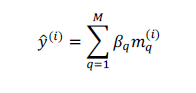




Image from: https://arxiv.org/ftp/arxiv/papers/2008/2008.07715.pdf


With M = set of "m"s  and the optimized "betas":

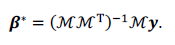

Image from: https://arxiv.org/ftp/arxiv/papers/2008/2008.07715.pdf

There is an scalar factor fz for observable quantities wich takes a set of observable quantities depending the model, in this case this hyperparameters is equal to all the set of observables, fz = 2. 

In [38]:
def betas_matrix(m,y):
    mq=np.array(m) 
    betas= np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(mq),mq )),np.transpose(mq)),y)
    return betas

In [39]:
def betas_model(theta,x,y):
    measure=[]
    for i in range(len(x)):
        m=qcircuit(theta, x[i])
        measure.append(m)
    mq=measure
    betas=betas_matrix(mq,y)
    return betas 

In [40]:
def predictor(theta,x,fz,betas):
    m=qcircuit(theta, x)
    m=m[0:fz]
    matriz_pr=[]
    for i in range(fz):
        pr=m[i,]*betas[i,]
        matriz_pr.append(pr)
    pred=np.sum(matriz_pr)
    return pred

In [41]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

In [42]:
def cost(theta,x,y,fz):
    betas=betas_model(theta,x,y)
    predi=[]
    for i in range(len(x)):
        pred=predictor(theta,x[i],fz,betas)
        predi.append(pred)
    predic=predi
    res=square_loss(y, predic)
    return res

Setting the hyperparameters with 2 qbits, 3 layers, fz=2 and applying Adam optimizer for gettting the values of theta that minimize the cost function:

In [43]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)
num_qubits = 2
num_layers = 3
fz=2
theta_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
theta = theta_init

In [44]:
print(theta_init)

[[[-0.01066219 -0.00466144  0.00348735]
  [-0.00140246 -0.02235699 -0.01095535]]

 [[-0.0060416   0.00712165 -0.02804185]
  [ 0.02580493  0.00618456  0.00589463]]

 [[-0.00993859  0.00256266 -0.00243132]
  [ 0.01367501 -0.02210988  0.01655903]]]


In [50]:
for it in range(10):
    theta = opt.step(lambda v: cost(v, X, Y, fz), theta)
    betas = betas_model(theta,X,Y)
    predics =[]
    for i in range(len(X)):
      p = predictor(theta,X[i],fz,betas) 
      predics.append(p)
    print("Iter: {:5d} | Cost: {:0.7f} | R2 Score {:0.5f}".format(it + 1, cost(theta, X, Y, fz), r2_score(Y, predics)))


Iter:     1 | Cost: 0.0203546 | R2 Score 0.96752
Iter:     2 | Cost: 0.0202555 | R2 Score 0.96768
Iter:     3 | Cost: 0.0201583 | R2 Score 0.96784
Iter:     4 | Cost: 0.0200629 | R2 Score 0.96799
Iter:     5 | Cost: 0.0199695 | R2 Score 0.96814
Iter:     6 | Cost: 0.0198779 | R2 Score 0.96828
Iter:     7 | Cost: 0.0197879 | R2 Score 0.96843
Iter:     8 | Cost: 0.0196991 | R2 Score 0.96857
Iter:     9 | Cost: 0.0196113 | R2 Score 0.96871
Iter:    10 | Cost: 0.0195242 | R2 Score 0.96885


In [51]:
print(theta, betas)

[[[-0.02397043  0.35283109 -0.01008763]
  [ 0.04388198  0.35952261  0.0726559 ]]

 [[-0.16938529  0.33715347 -0.18493568]
  [ 0.10941618  0.3624669   0.11444983]]

 [[-0.04905933  0.58524372 -0.06179887]
  [ 0.12223021  0.33308673  0.15268837]]] [-2.62630513  3.22373378]


We collect the predictions of the trained model for 50 values in the range [−1,1], just like the example of https://pennylane.ai/qml/demos/quantum_neural_net.html


In [52]:
x_pred = np.linspace(-1, 1, 50)
y_pred=[]
for i in range(len(X)):
      new_pred=predictor(theta,x_pred[i],fz,betas) 
      y_pred.append(new_pred)


Finally plotting the results we see that the model (red dots) have been learned from the data (blue dots) and has the similar shape and non linearity characteristic as the original.

### With 10 iterations

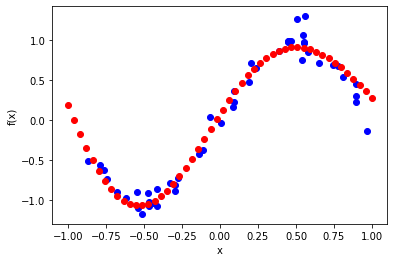

In [53]:
plt.figure()
plt.scatter(X, Y, color="blue")
plt.scatter(x_pred, y_pred, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()



### With 100 iterations

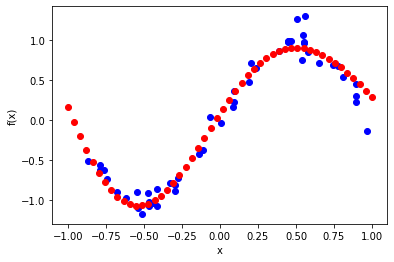

In [48]:
plt.figure()
plt.scatter(X, Y, color="blue")
plt.scatter(x_pred, y_pred, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

